In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from IPython.display import Image

## ** Tutorial 1 : $Cos$ curve 예측**
시간 $(t=1,...,2T)$에 대하여 
- $u \sim U(-1.0, 1.0)$ 
- $f(t)=cos(\frac{2\pi}{T}t)+0.05u$

#### **Cosine curve를 RNN을 이용하여 학습한 후, 학습된 RNN 모델을 이용하여 Cosine curve를 그려보자.**

In [2]:
# Plotting style
plt.style.use('ggplot')

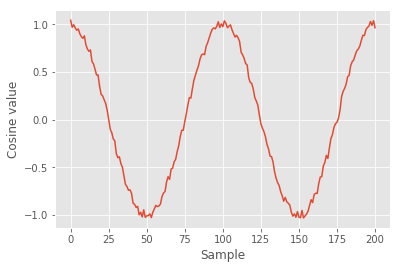

In [3]:
# Cos 커브 생성
def cos(x, T=100):
    return np.cos(2.0 * np.pi * x / T)

# 시각화를 위한 plotting 함수
def plot_curve(x, y):
    plt.plot(x, y)
    plt.xlabel('Sample')
    plt.ylabel('Cosine value')

def get_data(T=100, amp=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = amp * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    y = cos(x) + noise
    # 시각화를 위하여 plotting을 한다.
    plot_curve(x, y)
    return y

T = 100
f = get_data(T)

25개의 시계열 데이터 $x(t), x(t+1), ... , x(t+24)$를 이용하여 $x(t+25)$ 데이터를 예측하려고 한다.

In [4]:
# 전체 데이터의 길이
len_of_seqs = 2 * T
window_size = 25

# 1 ~ 25의 데이터를 이용하여 26번째 데이터를 예측한다.
time_data = []
target = []

for i in range(0, len_of_seqs - window_size + 1):
    time_data.append(f[i:i + window_size])
    target.append(f[i + window_size])

In [5]:
# RNN이 예측하려는 데이터의 관계를 살펴보자.
print('Input time series data : ')
print(time_data[0])
print('Target : ')
print(target[0])

Input time series data : 
[1.04117568 0.96741887 0.99450238 0.96201653 0.93602695 0.95007476
 0.89990932 0.86926085 0.85084911 0.87783765 0.78422219 0.73937023
 0.7152591  0.72986801 0.60797702 0.58331078 0.52771422 0.46712289
 0.46682882 0.34970414 0.26558571 0.24729766 0.20708248 0.16866162
 0.09581897]
Target : 
0.0010563174244186014


> 모델에 사용하는 input data($X$)의 shape은 $\mathbf{(n, \tau, I)}$가 된다.
>- Time series의 갯수: $\mathbf{n}$
>  - $x(t),x(t+1),...,x(t+24)$ 
>  - $x(t+1),x(t+2),...,x(t+25)$
>  - $x(t+2),x(t+3),...,x(t+26)$
>  - .....
>- Window size: $\tau$
>- $x(t)$의 차원 수: $\mathbf{I}$

Tensorflow에서 사용하는 RNN data의 shape은 다음을 참고하자.

<img src="image/RNN1.png" width="800" height="700">

In [6]:
# Input data를 정의한다.
X = np.array(time_data).reshape(len(time_data), window_size, 1)

In [7]:
Y = np.array(target).reshape(len(target), 1)

In [8]:
num_train = int(len(time_data) * 0.9)
num_validation = len(time_data) - num_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=num_validation)

In [9]:
def inference(x, batch_size, window_size=None, hidden_size=None, dim_output=None):
    ##### Model #####
    # RNN cell의 unit 수
    cell = tf.contrib.rnn.BasicRNNCell(hidden_size)
    # BasicRNNCell __call__의 argument이다. Batch sizer 정보를 이용하여 초기화한다.
    initial_state = cell.zero_state(batch_size, dtype=tf.float32)
    # Zero state를 state의 초기값으로 사용한다. 
    state = initial_state
    cell_outputs = []
    states = []
    
    """ BasicRNNCell의 __call__를 사용하고 싶은 경우 : 아래의 주석을 해제 """
#     with tf.variable_scope('RNN'):
#         for t in range(window_size):
#             if t > 0:
#                 tf.get_variable_scope().reuse_variables()
#             # Run this RNN cell on inputs, starting from the given state. (__call__)
#             # State in left side is current hidden state and those in right side is previous hidden state.
#             # 시간 t에서의 출력을 차례대로 계산한다. 
#             (cell_output, state) = cell(x[:, t, :], state)
#             cell_outputs.append(cell_output)
#             states.append(state)
#     final_cell_output = cell_outputs[-1]

    """ dynamic_rnn 사용하는 경우 """
    outputs, state = tf.nn.dynamic_rnn(cell, x, initial_state=initial_state, dtype=tf.float32)
    final_cell_output = outputs[:,-1,:]
    
    ##### Output #####        
    V = tf.Variable(tf.truncated_normal([hidden_size, dim_output], stddev=0.01))
    c = tf.Variable(tf.zeros([dim_output], dtype=tf.float32))
    
    # Activation function is linear function. Because, we predict Sin curve.
    y = tf.matmul(final_cell_output, V) + c
    
    return y

In [10]:
# Define loss function as MSE.
def get_loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

In [11]:
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

In [12]:
# Placeholder를 정의하기 위하여 필요한 상수값들
DIM_OUTPUT = 1
DIM_INPUT = 1
# Number of units in hidden cell
HIDDEN_SIZE = 20

In [13]:
# Define placehoder
# Window_size : the length of time serise, dim_input : dimesion of each time data in serise
x = tf.placeholder(tf.float32, shape=[None, window_size, DIM_INPUT])
t = tf.placeholder(tf.float32, shape=[None, DIM_OUTPUT])
# RNN cell의 initial_state에 넣어야되는 값은 vector, scala값 이다.
batch_size = tf.placeholder(tf.int32, [])

# Get the value of y (inference)
y = inference(x, batch_size, window_size, HIDDEN_SIZE, DIM_OUTPUT)
loss = get_loss(y, t)
train_step = training(loss)

In [14]:
# Constants
EPOCHS = 500
BATCH_SIZE = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

num_batches = num_train // BATCH_SIZE

### **Train**

In [15]:
history = {'val_loss':[]}

for epoch in range(EPOCHS):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(num_batches):
        start = i * BATCH_SIZE
        end = start + BATCH_SIZE
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            batch_size: BATCH_SIZE
        })
    
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        batch_size: num_validation
    })
    
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss:', val_loss)


epoch: 0  validation loss: 0.44326952
epoch: 1  validation loss: 0.25612208
epoch: 2  validation loss: 0.11992182
epoch: 3  validation loss: 0.047747016
epoch: 4  validation loss: 0.029754616
epoch: 5  validation loss: 0.019410444
epoch: 6  validation loss: 0.015743095
epoch: 7  validation loss: 0.017142273
epoch: 8  validation loss: 0.015834637
epoch: 9  validation loss: 0.01088973
epoch: 10  validation loss: 0.011440393
epoch: 11  validation loss: 0.010043338
epoch: 12  validation loss: 0.008560706
epoch: 13  validation loss: 0.008475001
epoch: 14  validation loss: 0.007858019
epoch: 15  validation loss: 0.00955357
epoch: 16  validation loss: 0.0077468925
epoch: 17  validation loss: 0.008395753
epoch: 18  validation loss: 0.0069115832
epoch: 19  validation loss: 0.0055168546
epoch: 20  validation loss: 0.004801674
epoch: 21  validation loss: 0.0043391576
epoch: 22  validation loss: 0.0043432927
epoch: 23  validation loss: 0.003893462
epoch: 24  validation loss: 0.0045445277
epoch: 25

### **Prediction**

In [16]:
truncate = window_size
# 데이터의 첫부분을 잘라낸다.
Z = X[:1]

In [17]:
original = [f[i] for i in range(window_size)]
predicted = [None for i in range(window_size)]

In [18]:
for i in range(len_of_seqs - window_size + 1):
    # 마지막 시계열 데이터로 미래를 예측한다.
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        batch_size: 1
    })
    
    sequence_ = np.concatenate(
        (z_.reshape(window_size, DIM_INPUT)[1:], y_), axis=0).reshape(1, window_size, DIM_INPUT)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))
    

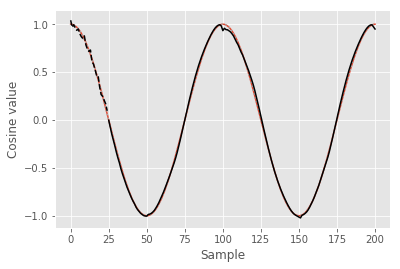

In [19]:
plt.figure()
plt.plot(get_data(T, amp=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()